In [3]:
# 1. Importar librerías
# -------------------------
import pandas as pd
import numpy as np
import networkx as nx
from scipy import stats
import random
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from google.colab import files
from sklearn.feature_selection import mutual_info_regression
import seaborn as sns
import io

# Para reproducibilidad
np.random.seed(42)
random.seed(42)

# -------------------------
# 2. Subir archivo de datos
# -------------------------
print("Por favor, sube el archivo 'ProduccionHCLEntidad1.csv'")
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# -------------------------
# 3. Cargar y preparar datos
# -------------------------
# Leer CSV y usar primera columna como índice
df = pd.read_csv(io.BytesIO(uploaded[filename]), index_col=0)

# Convertir todas las columnas a numeric (NaN si no se puede)
df = df.apply(pd.to_numeric, errors='coerce')

# Eliminar columnas que sean completamente NaN
df = df.dropna(axis=1, how='all')

# Transponer para que las filas sean fechas y columnas entidades
df = df.T

# Intentar convertir índice a datetime
df.index = pd.to_datetime(df.index, errors='coerce')

# Eliminar filas con fechas inválidas
df = df[~df.index.isna()]

# Mostrar información del dataset
print("\nInformación del dataset:")
print(f"Dimensiones: {df.shape}")
print(f"Columnas: {list(df.columns)}")
if pd.api.types.is_datetime64_any_dtype(df.index):
    print(f"Rango de fechas: {df.index.min().date()} a {df.index.max().date()}")
else:
    print("Rango de fechas no disponible (índice no es datetime)")
print("\nPrimeras 5 filas:")
print(df.head())

print("\n¡Dataset cargado y preprocesado exitosamente! Puedes continuar con tu análisis.")


Por favor, sube el archivo 'ProduccionHCLEntidad1.csv'


Saving estadisticasOperativas (copy).csv to estadisticasOperativas (copy) (1).csv

Información del dataset:
Dimensiones: (61, 56)
Columnas: ['Producción Petroleo crudo', 'Producción Condensados y liquidos del gas', 'Producción Gas natural  (MMpcd)', 'Producción Petroliferos y gas licuado (1)', 'Producción Petroquimicos (Mt) (2)', 'Producción Naftas (Mt)', 'Producción Proceso de crudo', 'Volumen Gas licuado (3)', 'Volumen Pemex Magna', 'Volumen Pemex Premium', 'Volumen Turbosina', 'Volumen Diesel', 'Volumen Combustoleo', 'Volumen Otros (4)', 'Volumen Gas natural (MMpcd)', 'Volumen Complejos Petroquimicos (5)', 'Volumen Sistema Nacional de Refinacion', 'Volumen Complejos Procesadores de Gas (6)', 'Valor Gas licuado (3)', 'Valor Pemex Magna', 'Valor Pemex Premium', 'Valor Turbosina', 'Valor Diesel', 'Valor Combustoleo', 'Valor Otros (4)', 'Valor Gas natural', 'Valor Complejos Petroquimicos (5)', 'Valor Sistema Nacional de Refinacion', 'Valor Complejos Procesadores de Gas (6)', 'Volumen Ex

/tmp/ipython-input-1808966775.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index, errors='coerce')


In [4]:
# -------------------------
# 4. Preprocesamiento
# -------------------------

# Convertir todas las columnas a numéricas (forzando errores a NaN)
df = df.apply(pd.to_numeric, errors="coerce")

# Rellenar/limpiar: interpolar o dropna según calidad
df = df.interpolate().dropna(axis=1, how='any')

# Normalizar series (z-score temporal)
scaler = StandardScaler()
Z = pd.DataFrame(scaler.fit_transform(df.values), index=df.index, columns=df.columns)

In [5]:
# --------------------------------------------------------
# 5. Bosque Aleatorios para Identificar Nodos Estrategicos
# --------------------------------------------------------

from sklearn.ensemble import RandomForestRegressor

# Supongamos que quieres predecir Producción Petróleo crudo
target = "Precio Exportacion Petroleo crudo (8)"

# Variables predictoras: todas menos la target
X = Z.drop(columns=[target])
y = Z[target]

# Modelo de Random Forest
rf = RandomForestRegressor(
    n_estimators=500,
    random_state=42,
    max_depth=None, #
    n_jobs=-1
)

rf.fit(X, y)


RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=42)

In [6]:
# Importancia de variables
importancias = pd.Series(rf.feature_importances_, index=X.columns)
importancias = importancias.sort_values(ascending=False)

print(importancias.head(10))  # Top 10 nodos estratégicos

Precio Exportacion Maya                           0.447417
Precio Exportacion Istmo                          0.212045
Precio Exportacion Combustoleo (alto azufre)      0.117502
Precio Importacion Combustoleo (bajo azufre)      0.044472
Precio Importacion Gasolinas                      0.036944
Valor Exportaciones Petroliferos y Gas Licuado    0.015204
Valor Pemex Magna                                 0.014767
Valor Exportacion de petroleo crudo               0.012258
Valor Complejos Procesadores de Gas (6)           0.008333
Valor Diesel                                      0.008055
dtype: float64


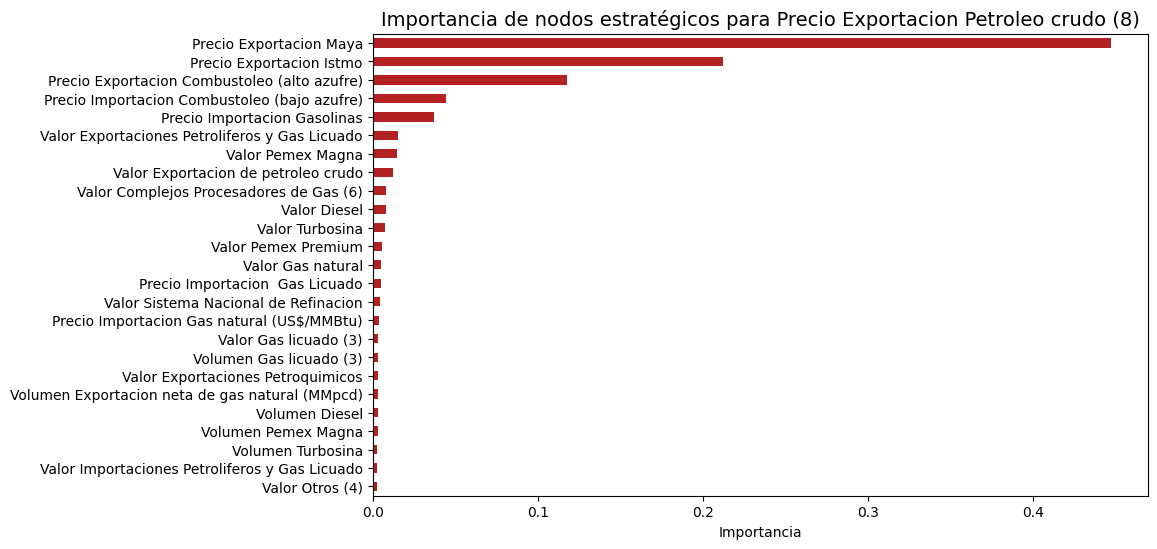

In [7]:
# Generación de Gráfica

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
importancias.head(25).plot(kind="barh", color="firebrick")
plt.gca().invert_yaxis()
plt.title(f"Importancia de nodos estratégicos para {target}", fontsize=14)
plt.xlabel("Importancia")
plt.show()

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predicciones
y_pred = rf.predict(X)

# Métricas de desempeño
mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

print("MSE:", mse)
print("MAE:", mae)
print("R2 Score:", r2)


MSE: 0.005979318106867244
MAE: 0.04335056147558759
R2 Score: 0.9940206818931328


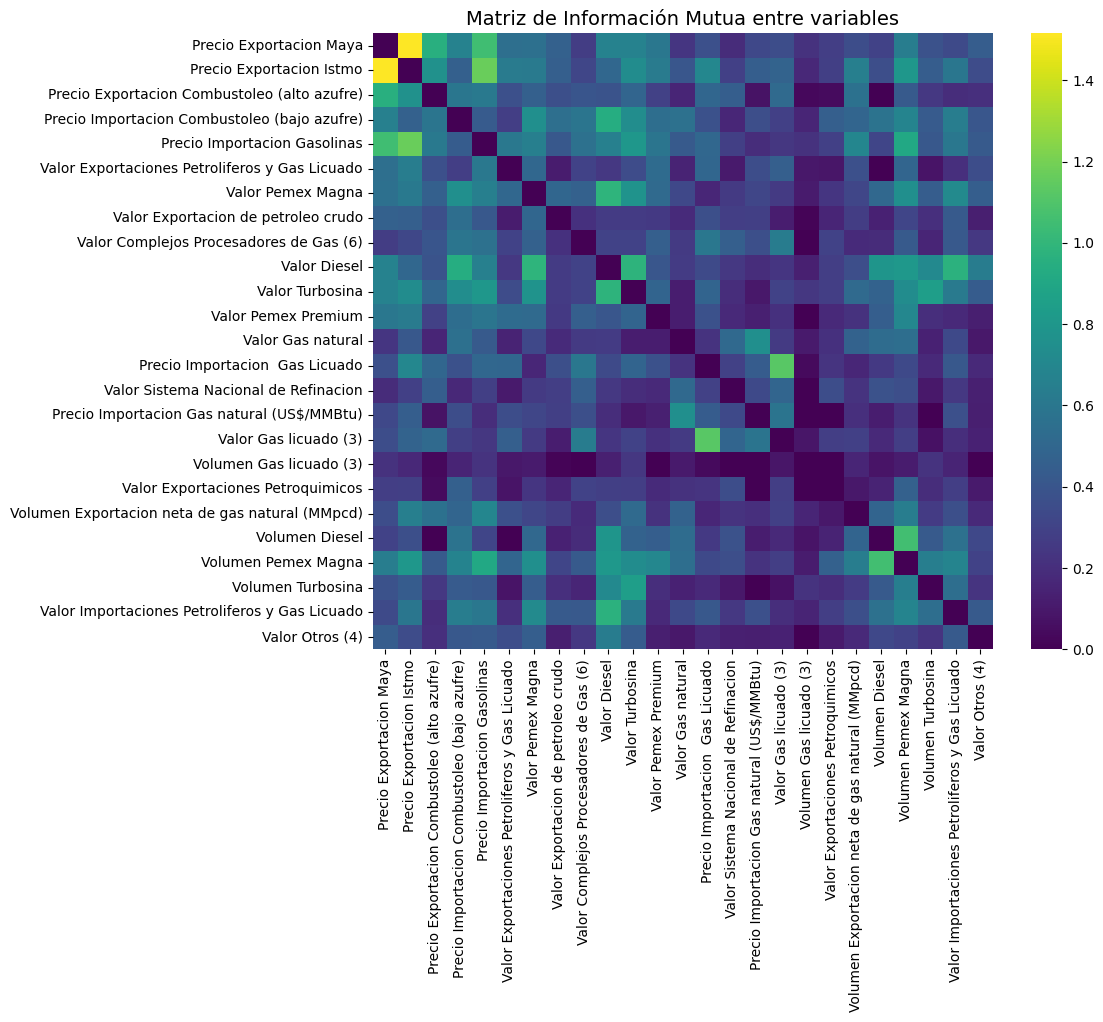

In [9]:
# --------------------------
# 5. Matriz Información Mutua
# --------------------------


# --- Paso 1. Filtrar las variables que quieres ---

#cols = list(importancias.axes[0])
cols = list(importancias.iloc[:25].axes[0]) # Resultado de Random Forest, Cambiar número en iloc para determinar número de nodos
X = Z[cols]

# --- Paso 2. Matriz de Información Mutua ---
n = len(cols)
MI = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        if i != j:
            # mutual_info_regression espera X como matriz 2D
            MI[i, j] = mutual_info_regression(
                X[[cols[i]]],  # variable X
                X[cols[j]]     # variable Y
            )[0]
        else:
            MI[i, j] = 0  # diagonal en 0

MI_df = pd.DataFrame(MI, index=cols, columns=cols) # DataFrame Información Mutua

# --- Paso 3. Visualización ---
plt.figure(figsize=(10, 8))
sns.heatmap(MI_df, cmap="viridis", xticklabels=cols, yticklabels=cols)
plt.title("Matriz de Información Mutua entre variables", fontsize=14)
plt.show()


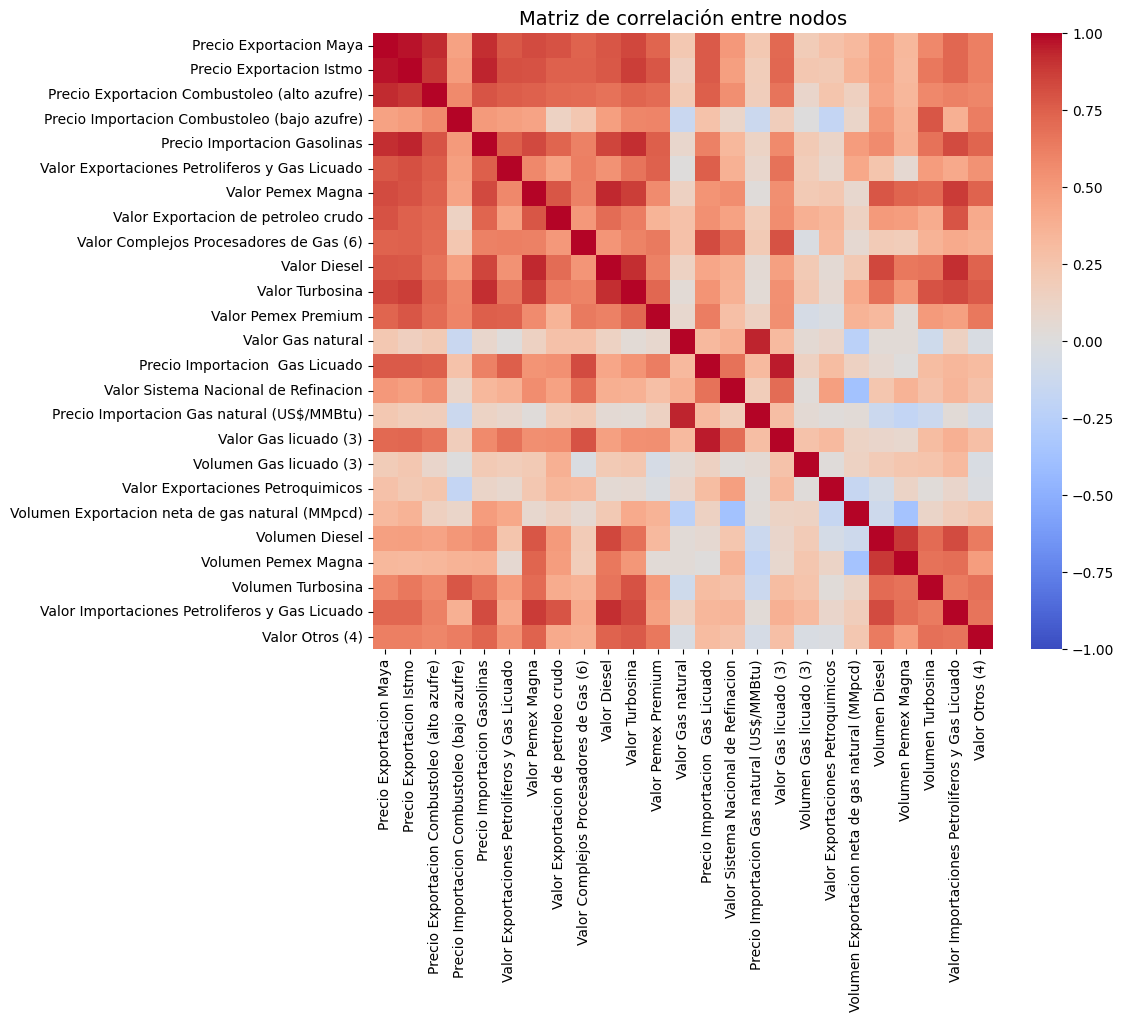

In [10]:
# -------------------------
# 6. Matriz de dependencia (Pearson y Spearman)
# -------------------------
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# Lista de atributos relevantes
atributos = cols

# Filtrar dataset solo con esas columnas al usar Random Forest
Z = Z[atributos]

# Matriz de correlación Pearson
corr = Z.corr(method='pearson')

# Matriz de correlación Spearman
#corr = Z.corr(method='spearman')


# Visualización con heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm", vmin=-1, vmax=1,
            xticklabels=corr.columns, yticklabels=corr.columns)

plt.title("Matriz de correlación entre nodos", fontsize=14)
plt.show()



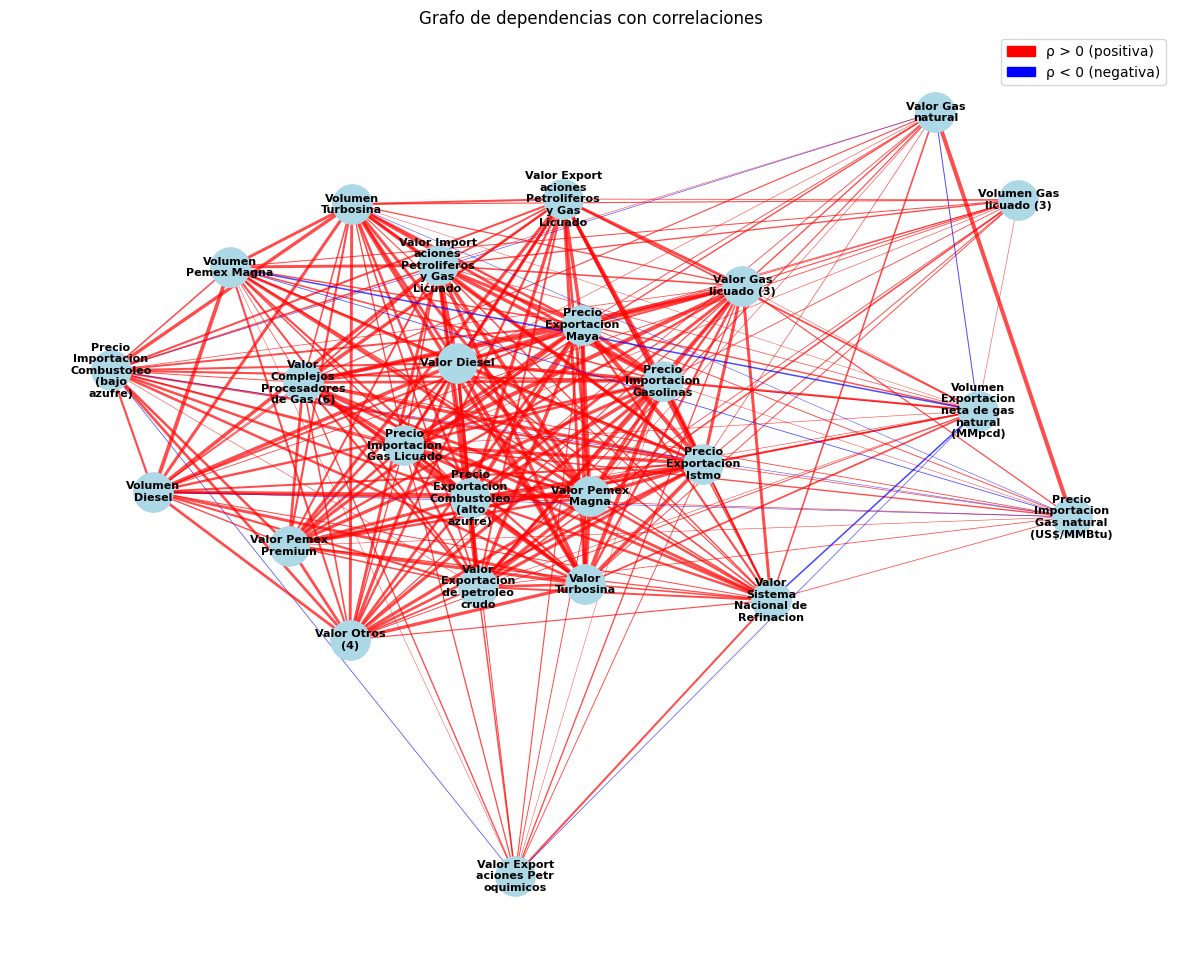

In [16]:
# -------------------------
# 7. Umbral y grafo binario (top 15% de aristas)
# -------------------------

W = corr.abs().values  # usar |ρ| como peso
#W = MI_df.abs().values  # usar |MI| como peso

n = W.shape[0]
triu_idx = np.triu_indices(n, k=1)  # diagonal excluida
weights_upper = W[triu_idx]
k = 0.85 # densidad objetivo
m = int(k * len(weights_upper))
th = np.sort(weights_upper)[-m] if m > 0 else 1.1

A = (W >= th).astype(int)
np.fill_diagonal(A, 0)

# Crear grafo NetworkX (no dirigido)
G = nx.from_numpy_array(A)
mapping = {i: col for i, col in enumerate(Z.columns)}
G = nx.relabel_nodes(G, mapping)

# -------------------------
# 8. Preparar pesos y colores de aristas
# -------------------------

cols = list(Z.columns)
edge_weights = []
edge_colors = []

for u, v in G.edges():
    i, j = cols.index(u), cols.index(v)
    w = corr.values[i, j]  # siempre devuelve float
    G[u][v]["weight"] = abs(w)
    edge_weights.append(abs(w))
    edge_colors.append("red" if w > 0 else "blue")


# Normalizar grosor de aristas
max_w = max(edge_weights) if edge_weights else 1
edge_widths = [3 * (w / max_w) for w in edge_weights]  # grosor entre 0 y 3

# -------------------------
# 9. Dibujar grafo
# -------------------------
pos = nx.spring_layout(G, seed=42, k=1.5)  # k controla la distancia ideal entre nodos

import textwrap

labels = {n: "\n".join(textwrap.wrap(n, width=12)) for n in G.nodes()}

plt.figure(figsize=(15, 12))
nx.draw_networkx_nodes(G, pos, node_size=800, node_color="lightblue")
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, font_weight="bold")
nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=edge_colors, alpha=0.7)


# Leyenda
red_patch = mpatches.Patch(color="red", label="ρ > 0 (positiva)")
blue_patch = mpatches.Patch(color="blue", label="ρ < 0 (negativa)")
plt.legend(handles=[red_patch, blue_patch], loc="upper right")

plt.title("Grafo de dependencias con correlaciones")
#plt.title("Grafo de dependencias con Información Mutua")
plt.axis("off")
plt.show()



In [ ]:
# -----------------------
# Generar grafo en .html
# -----------------------

#!pip install pyvis
from pyvis.network import Network

net = Network(notebook=True, height="600px", width="100%", bgcolor="#ffffff", font_color="black")
net.from_nx(G)
net.show("grafo.html")

grafo.html


In [ ]:
files.download("grafo.html")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
# -------------------------
#10. Medidas de red
# -------------------------
C = nx.average_clustering(G)                            # coef. agrupamiento
if nx.is_connected(G):
    L = nx.average_shortest_path_length(G)
else:
    # usar componente gigante
    giant = max(nx.connected_components(G), key=len)
    L = nx.average_shortest_path_length(G.subgraph(giant))

print(f"C = {C:.4f}, L = {L:.4f}, n={G.number_of_nodes()}, m={G.number_of_edges()}")


C = 0.8811, L = 1.1500, n=25, m=255


In [ ]:
import numpy as np
import nashpy as nash
import networkx as nx
import matplotlib.pyplot as plt

# -------------------------
# Obtener matriz de utilidad a partir de los pesos
# -------------------------
nodes = list(G.nodes())
n = len(nodes)

U = np.zeros((n, n))
for i, u in enumerate(nodes):
    for j, v in enumerate(nodes):
        if G.has_edge(u, v):
            U[i, j] = G[u][v]["weight"]

print("Matriz de utilidad U:")
print(U)

Matriz de utilidad U:
[[0.         0.94553002 0.80697533 ... 0.         0.         0.4451995 ]
 [0.94553002 0.         0.75070732 ... 0.36211957 0.3748116  0.58592242]
 [0.80697533 0.75070732 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.36211957 0.         ... 0.         0.33456728 0.54033687]
 [0.         0.3748116  0.         ... 0.33456728 0.         0.40236389]
 [0.4451995  0.58592242 0.         ... 0.54033687 0.40236389 0.        ]]


In [ ]:
# ---------------------------
# 11. Configuración del juego
# ---------------------------
n = len(G.nodes)
resource_budget = 1.0   # presupuesto máximo de cada jugador
iterations = 100        # iteraciones para convergencia

# Inicialización de estrategias (asignación de recursos a vecinos) Generadas según distribución Dirichlet
strategies = {i: np.random.dirichlet(np.ones(len(G[i]))) if len(G[i])>0 else []
              for i in G.nodes}

# ---------------------------
# 12. Función de utilidad
# ---------------------------
def utility(node, strategy, neighbor_strategies):
    """
    node: jugador actual
    strategy: vector de asignación de recursos a cada vecino
    neighbor_strategies: estrategias de vecinos hacia este nodo
    """
    payoff = 0
    neighbors = list(G[node])
    for idx, neigh in enumerate(neighbors):
        w = G[node][neigh]['weight']  # peso arista
        # beneficio mutuo si ambos se asignan recursos
        payoff += w * strategy[idx] * neighbor_strategies[neigh].get(node, 0)
    # penalización por dispersión de recursos (coste cuadrático)
    payoff -= 0.1 * np.sum(np.square(strategy))
    return payoff


# ---------------------------
# 13. Dinámica de mejor respuesta
# ---------------------------
def best_response(node, strategies):
    neighbors = list(G[node])
    if not neighbors:
        return {}

    best_strat = None
    best_payoff = -np.inf

    # explorar varias posibles asignaciones (simulación discreta)
    for _ in range(100):
        proposal = np.random.dirichlet(np.ones(len(neighbors))) * resource_budget
        neigh_strats = {
            neigh: {node: strategies[neigh][list(G[neigh]).index(node)]}
            if node in G[neigh] else {}
            for neigh in neighbors
        }
        u = utility(node, proposal, neigh_strats)
        if u > best_payoff:
            best_payoff = u
            best_strat = proposal

    return dict(zip(neighbors, best_strat))

# Ejecutar dinámica iterativa
for _ in range(iterations):
    for node in G.nodes:
        strategies[node] = list(best_response(node, strategies).values())



In [ ]:
print(strategies)

{'Precio Exportacion Maya': [np.float64(0.14747134721979774), np.float64(0.007524957110210838), np.float64(0.04955931084239801), np.float64(0.06484683303667974), np.float64(0.004459944166643204), np.float64(0.005387045775073762), np.float64(0.010626697282280634), np.float64(0.014916275184439864), np.float64(0.011260648176774938), np.float64(0.008712728849928438), np.float64(0.06697762074027173), np.float64(0.06458063504697563), np.float64(0.08282782281960138), np.float64(0.0024656353653712726), np.float64(0.09981586999496062), np.float64(0.030170138477168096), np.float64(0.0035341117855292137), np.float64(0.011888612970860007), np.float64(0.0016683983724814846), np.float64(0.027692051699276098), np.float64(0.06504192451160662), np.float64(0.054532767131943743), np.float64(0.0016879371247162656), np.float64(0.03537400420764327), np.float64(0.0076012135161411965), np.float64(0.018383201591307775), np.float64(0.053051771783070446), np.float64(0.013490725303156733), np.float64(0.0028609538

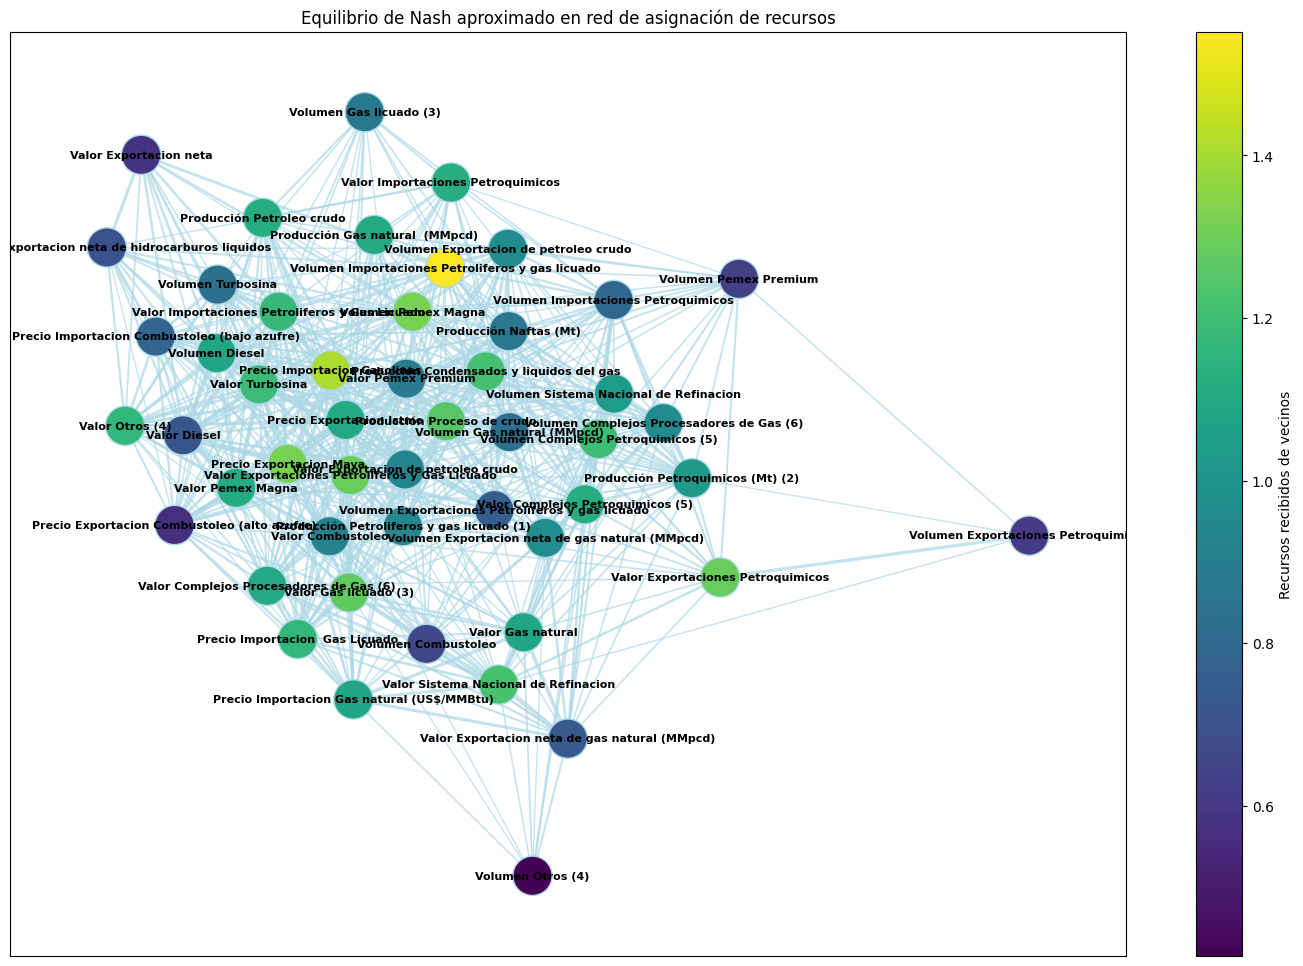

In [ ]:
# ---------------------------
# 14. Visualización de resultados
# ---------------------------
# Asignar a cada nodo los recursos que recibe de sus vecinos
node_received = {i: 0 for i in G.nodes}
for j in G.nodes:
    for idx, neigh in enumerate(G[j]):
        node_received[neigh] += strategies[j][idx]  # lo que j asigna al vecino


# Graficar
pos = nx.spring_layout(G, seed=42, k=0.7, iterations=50)
plt.figure(figsize=(18,12))

nx.draw_networkx_edges(
    G, pos,
    width=[d['weight']*3 for _,_,d in G.edges(data=True)],
    alpha=0.7,
    edge_color= "lightblue"
)

nodes = nx.draw_networkx_nodes(
    G, pos,
    node_color=list(node_received.values()),  # usamos recibidos
    cmap=plt.cm.viridis,
    edgecolors="lightblue",
    node_size=800
)

nx.draw_networkx_labels(G, pos, font_color='black', font_weight="bold", font_size=8)
plt.colorbar(nodes, label="Recursos recibidos de vecinos")
plt.title("Equilibrio de Nash aproximado en red de asignación de recursos")
plt.show()


In [ ]:
\node (im) [below right=2cm and 1cm of preprocess] {Cálculo de matriz de información mutua};
\node (threshold) [below=3cm of preprocess] {Determinación de umbral basado en densidad};
\node (network) [below of=threshold] {Construcción de red de dependencia};
\node (features) [below of=network] {Extracción de características topológicas};
\node (split) [below of=features] {División en entrenamiento y prueba};
\node (train) [below of=split] {Entrenamiento Random Forest};
\node (eval) [below of=train] {Evaluación y métricas};
\node (end) [below of=eval] {Análisis de resultados};

\draw[->] (preprocess) -| (im);
\draw[->] (corr) |- (threshold);
\draw[->] (im) |- (threshold);
\draw[->] (threshold) -- (network);
\draw[->] (network) -- (features);
\draw[->] (features) -- (split);
\draw[->] (split) -- (train);
\draw[->] (train) -- (eval);
\draw[->] (eval) -- (end);